In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## Load Dataset

In [2]:
test = pd.read_csv('test_table.csv')
user = pd.read_csv('user_table.csv')

In [4]:
print(test.shape)
test.head()

(453321, 9)


,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [5]:
print(user.shape)
user.head()

(452867, 4)


,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [6]:
# Check uniqueness
print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))
print('User ID:\t', len(user['user_id'].unique()), '\t', len(user['user_id'].unique()) == len(user)) 

Test ID:	 453321 	 True
User ID:	 452867 	 True


## Merging Tables

In [7]:
data = pd.merge(test,
               user,
               how = 'left', on = 'user_id')

In [8]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico


## EDA 

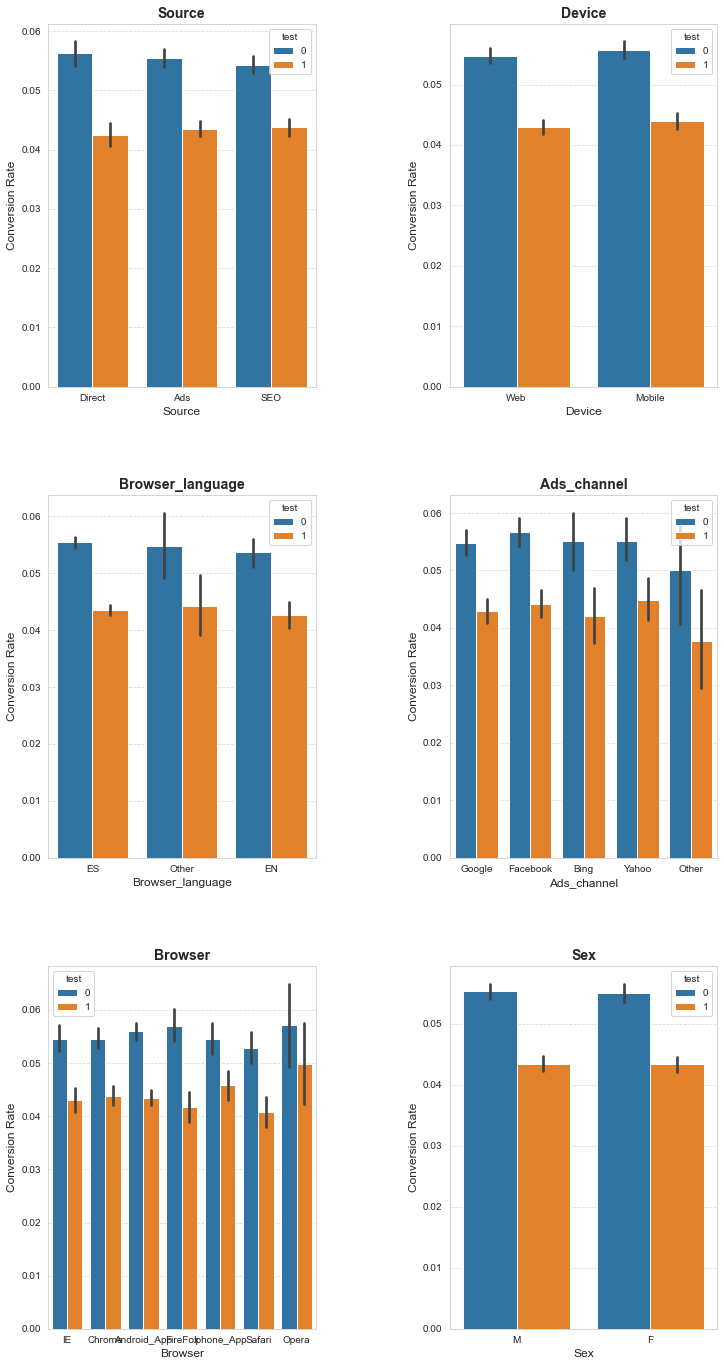

In [37]:
# Define the features to visualize
feature = ['source','device','browser_language','ads_channel','browser','sex']

# Create subplots of bar charts
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,24))
plt.subplots_adjust(hspace=0.3, wspace=0.5)  # Adjust spacing between subplots

# Iterate through each feature and create a bar chart subplot
for i, f in enumerate(feature):
    row = i // 2  # Compute the row and column indices for the current subplot
    col = i % 2
    sns.barplot(x=f, y='conversion', hue='test', data=data, ax=ax[row, col])  # Change color scheme
    ax[row, col].set_title(f.capitalize(), fontsize=14, fontweight='bold')  # Add title
    ax[row, col].set_xlabel(f.capitalize(), fontsize=12)  # Add x-axis label
    ax[row, col].set_ylabel('Conversion Rate', fontsize=12)  # Add y-axis label
    ax[row, col].tick_params(axis='both', labelsize=10)  # Increase font size of tick labels
    ax[row, col].grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

plt.show()

Let's check if Spain converts much better than the rest of the Latin American countries.

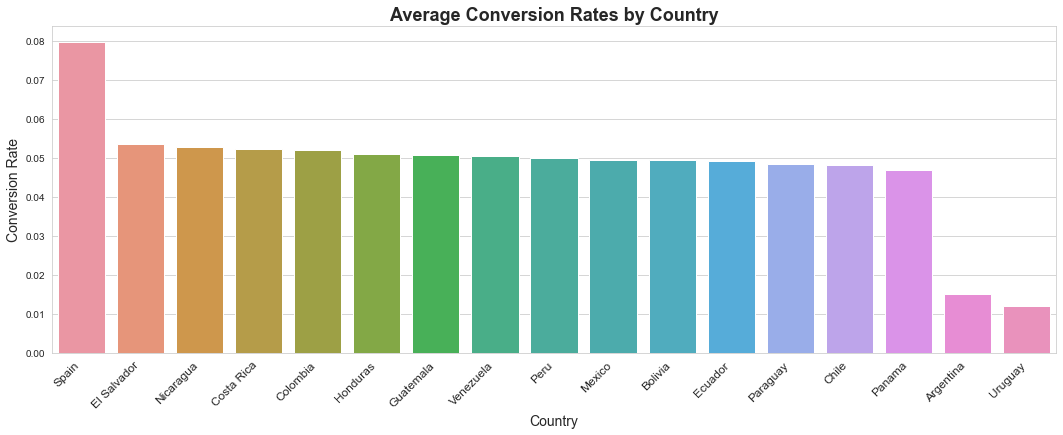

In [11]:
groupby_country = data[data['test'] == 0][['conversion', 'country']].groupby('country').mean()
groupby_country = groupby_country.reset_index()
groupby_country = groupby_country.sort_values('conversion', ascending=False)

fig, ax = plt.subplots(figsize=(18, 6))
sns.set_style("whitegrid")  # Add horizontal grid lines
sns.barplot(x='country', y='conversion', data=groupby_country, ax=ax)  # Change color scheme
ax.set_title("Average Conversion Rates by Country", fontsize=18, fontweight='bold')  # Add title
ax.set_xlabel("Country", fontsize=14)  # Add x-axis label
ax.set_ylabel("Conversion Rate", fontsize=14)  # Add y-axis label
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels and increase font size
plt.show()

Yes, it's definitely true.

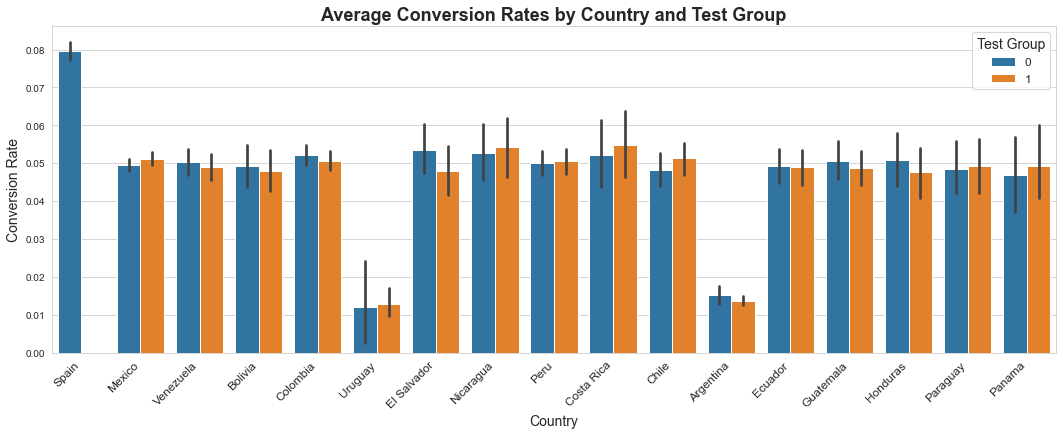

In [30]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='country', y='conversion', hue='test', data=data, ax=ax)  # Change color scheme
ax.set_title("Average Conversion Rates by Country and Test Group", fontsize=18, fontweight='bold')  # Add title
ax.set_xlabel("Country", fontsize=14)  # Add x-axis label
ax.set_ylabel("Conversion Rate", fontsize=14)  # Add y-axis label
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels and increase font size
ax.legend(title='Test Group', fontsize=12, title_fontsize=14)  # Add legend with title and increase font sizes
plt.show()

## Welch T Test

In [23]:
test_data = data[data.country != 'Spain']
test_conversion = test_data.loc[test_data['test'] == 1, 'conversion'].values
control_conversion = test_data.loc[test_data['test'] == 0, 'conversion'].values
print('Test mean conversion rate: ',test_conversion.mean(), '\n', 'Control mean conversion rate: ', control_conversion.mean())

Test mean conversion rate:  0.043424713982118966 
 Control mean conversion rate:  0.04833042316066309


In [24]:
print(ttest_ind(test_conversion, control_conversion, equal_var=False))

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)


Well, it seems that the local translation makes it even worse. Control group is converting at 4.8% while the test group is just at 4.3%. That’s a 10% drop, which would be dramatic if it were true. The most likely reason for weird A/B test results are:

* We didn’t collect enough data.

* Some bias has been introduced in the experiment so that test/control people are not really random.

Let's plot day by day, to see if weird results have been constantly happening or they just started happening all of a sudden.

In [42]:
control_group = data.loc[data.test==0, 'conversion'].groupby(data.loc[data.test==0, 'date']).mean()
test_group = data.loc[data.test==1, 'conversion'].groupby(data.loc[data.test==1, 'date']).mean()

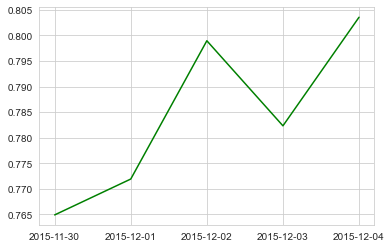

In [47]:
plt.plot(np.sort(data.loc[data.test==0, 'date'].unique()), test_group/control_group, 'g-')
plt.show()

From the plot, we notice a couple of things:

1. Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up.

2. On a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better.

Time to find out the bias! Likely, there is for some reason some segment of usersmore likely to endup in test or in control, this segment had a significantly above/below conversion rate and thisaffected the overall results.

## Model Building

In an ideal world, the distribution of people in test and control for each segment should be the same. There are many ways to check this. One way is to build a decision tree where the variables are the user dimensions and the outcome variable is whether the user is in test or control. If the tree splits, it means that for given values of that variable you are more likely to end up in test or control. But this should be impossible! Therefore, if the randomization worked, the tree should not split at all (or at least not be able to separate the two classes well).

Let’s check this:

In [50]:
labelencoder = LabelEncoder()
data_encoded = data.apply(labelencoder.fit_transform)
data_encoded.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,143076,3,1,1,1,5,3,1,0,1,14,14
1,225673,4,0,1,1,2,3,0,1,1,3,9
2,384705,4,0,1,1,1,1,0,0,1,16,14
3,131601,3,0,0,2,1,0,0,1,0,4,9
4,248562,0,0,1,1,2,2,0,1,1,1,9


In [53]:
X = data_encoded.loc[:,data_encoded.columns != 'conversion']
y = data_encoded['conversion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(317324, 11) (135997, 11) (317324,) (135997,)


In [54]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

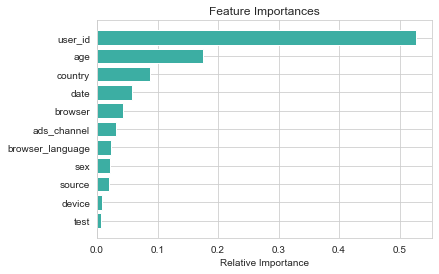

In [56]:
features = data.columns[data.columns != 'conversion']
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#3CAEA3', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

We see that country might be an important feature for conversion. Now, let's check by different countries:

In [62]:
countries = [name for name in data['country'].unique() if name is not np.nan and name != 'Spain']

print('{0:15s} {1:>15s} {2:>15s} {3:>10s}'.format('Country', 'Test Rate', 'Control Rate', 'P-Value'))
print('-' * 65)
for country in countries:
    test_val = data[(data['country'] == country) & (data['test'] == 1)]['conversion'].values
    cont_val = data[(data['country'] == country) & (data['test'] == 0)]['conversion'].values
    
    if len(test_val) > 0:
        test_mean = test_val.mean()
    else:
        test_mean = 0
    cont_mean = cont_val.mean()
    p_val = ttest_ind(test_val, cont_val, equal_var=False).pvalue
    
    print('{0:15s} {1:15.5f} {2:15.5f} {3:10f}'.format(country, test_mean, cont_mean, p_val))

Country               Test Rate    Control Rate    P-Value
-----------------------------------------------------------------
Mexico                  0.05119         0.04949   0.165544
Venezuela               0.04898         0.05034   0.573702
Bolivia                 0.04790         0.04937   0.718885
Colombia                0.05057         0.05209   0.423719
Uruguay                 0.01291         0.01205   0.879764
El Salvador             0.04795         0.05355   0.248127
Nicaragua               0.05418         0.05265   0.780400
Peru                    0.05060         0.04991   0.771953
Costa Rica              0.05474         0.05226   0.687876
Chile                   0.05130         0.04811   0.302848
Argentina               0.01373         0.01507   0.335147
Ecuador                 0.04899         0.04915   0.961512
Guatemala               0.04865         0.05064   0.572107
Honduras                0.04754         0.05091   0.471463
Paraguay                0.04923         0.04849  

After we control for country, the test clearly appears non significant. Not a great success given that the goal was to improve conversion rate, but at least we know that a localized translation didn’t make things worse!